In [176]:
%%writefile README.md
# LINE1 PILEUP

Get regulatory potent LINE1 from HG38 and pileup them according to the relative to 5'-end location of CpG sites.

---

Overwriting README.md


In [150]:
%%writefile download_files.sh
#! /bin/bash
# helper file to download ref genome and LINE1 coordinates

bedtools=$(which bedtools)
samtools=$(which samtools)
aria2c=$(which aria2c)

DATA='./data'
LINE1='http://l1base.charite.de/BED/hsflnil1_8438_rm.bed'
HG38='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz'

function downloadFile {
    URL=$1
    filename=$(basename ${URL})
    
    if [ ! -f ${filename} ] 
    then 
        if command -v $aria2c &> /dev/null
        then
        $aria2c ${URL} -o ${filename}.tmp
        else
        wget ${URL} -O ${filename}.tmp
        fi
    mv ${filename}{.tmp,}
    fi
}

mkdir -p $DATA && cd $DATA

# get files if not exist

if [ ! -f regulatory_potent_LINE1_gh38.bed ]
then downloadFile ${LINE1} && cat $(basename ${LINE1}) \
| awk -v OFS="\t" '{if (NR!=1) print $1, $2, $3, $4, $5, $6}' \
> regulatory_potent_LINE1_hg38.bed.tmp && mv regulatory_potent_LINE1_hg38.bed{.tmp,} 
fi

if [ ! -f hg38.fa ] 
then downloadFile ${HG38} && zcat $(basename ${HG38}) > hg38.fa.tmp && mv hg38.fa{.tmp,} 
fi

# main part

$samtools faidx hg38.fa

# NB! the output sequence will be reverse complemented
$bedtools getfasta -bedOut -s -name -fi hg38.fa -bed regulatory_potent_LINE1_hg38.bed \
> regulatory_potent_LINE1_hg38.seq.bed

cd ..

Overwriting download_files.sh


In [149]:
! chmod +755 download_files.sh && ./download_files.sh

In [178]:
! head -n10 ./data/regulatory_potent_LINE1_hg38.seq.bed | less -S

chr19   54579701        54589400        UID-1   0       -       ctcctgagtagctgg>
chr19   27280054        27289914        UID-2   0       -       tgaagatatttcctt>
chr19   27320867        27330838        UID-3   0       +       caccagcatggcact>
chr19   42743461        42753352        UID-4   0       -       tagttcctccaattc>
chr19   42768603        42778611        UID-5   0       -       tataagctggaggtg>
chr19   43241553        43251605        UID-6   0       -       tttctcttgtgctgg>
chr19   24147029        24157203        UID-7   0       -       GAGACCCAGTGGGAA>
chr19   24405424        24414492        UID-8   0       -       ccacaatgagatacc>
chr19   29222280        29232307        UID-9   0       +       TAACCCCCTTTTCTT>
chr19   23429633        23439785        UID-10  0       -       CCCGGTCTTGCCCAG>
(END)

In [152]:
# how many

! wc -l < ./data/regulatory_potent_LINE1_hg38.seq.bed

13418


In [159]:
# what is the longest seq?

! cat ./data/regulatory_potent_LINE1_hg38.seq.bed \
| awk '{print length($7)}' | sort -nr | head -n1

12594
sort: write failed: 'standard output': Broken pipe
sort: write error


In [212]:
%%writefile bam2wt.py
# read bed with seq from stdout
# use wavelets to localize CpG sites in both time and frequency (i.e., the order and density) domains

import pywt # mamba install pywavelets
import numpy as np
import sys, argparse

def truncate() -> int:
    """Read arguments from command line

    Returns:
        int: the number of bases to keep, the wavelet level
    """
    parser = argparse.ArgumentParser()

    parser.add_argument('bases', type=int, help='- how many bases to keep in 5\' to 3\' direction')
    parser.add_argument('level', type=int, help='- what is the wavelet decomposition level, i.e., the level 2 for 1000 bases will report 250 points')

    args = parser.parse_args()

    return args.bases, args.level

def get_mother_WT(data: np.ndarray, restored = False, level = 1) -> np.ndarray:
    """Wavelet decomposition

    Args:
        data (np.ndarray): array of time series values
        restored (bool, optional): return the "smoothed" = True or "compressed" = False. Defaults to False.
        level (int, optional): Wavelets decomposition level ("compression"). Defaults to 1.

    Returns:
        np.ndarray: result of wavelet decomposition
    """
    wavelet_family = 'haar'
    mode = 'smooth'
    coeff_all = pywt.wavedec(
        data, 
        wavelet = wavelet_family, 
        mode=mode, 
        level=level)
    cA, cD = coeff_all[0], coeff_all[1:]
    
    if restored:
        n = data.shape[0]
        omp0 = pywt.upcoef('a', cA, wavelet_family, level=level)[:n]
        return omp0 # restored mother wavelet
    else:
        return cA # compressed mother wavelet

def seq2boolean(seq: str) -> np.ndarray:
    """Convert a sequence to its boolean representation
    replace CG (case sensitive) by "1", other bases by "0"

    Args:
        seq (str): DNA sequence

    Returns:
        np.ndarray: result
    """
    seq = seq.replace('CG', '10').lower() # replace CG

    for _ in 'atgcn': # all other bases
        seq = seq.replace(_, '0')

    return np.asarray(list(seq)).astype(int)

def read_stdin() -> str:
    for line in sys.stdin:
        yield line.rstrip()
        
# main

bases, level = truncate()

read_stdin_generator = read_stdin()       

line = next(read_stdin_generator, False)

while line:

    # get tab separated string like this:
    # chr19	54579701	54589400	UID-1	0	-	ctc...

    chrom, start, end, name, quality, strand, seq = line.split('\t')

    if len(seq) < bases:
        seq = seq.rjust(bases, '0')

    seq = seq[:bases]

    boolean_seq = seq2boolean(seq)
    
    wavelet = get_mother_WT(boolean_seq, False, level)

    # return the region details and the seq wavelet
    print(
        f'{name}::{chrom}:{start}-{end}({strand})',
        *wavelet,
        sep='\t',
        file=sys.stdout)

    line = next(read_stdin_generator, False)

sys.exit(0)

Overwriting bam2wt.py


In [28]:
! head -n5 ./data/regulatory_potent_LINE1_hg38.seq.bed | python bam2wt.py 800 3

UID-1::chr19:54579701-54589400(-)	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.35355339059327384	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.35355339059327384	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
UID-2::chr19:27280054-27289914(-)	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
UID-3::chr19:27320867-27330838(+)	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.

In [34]:
# convert and compress
# take the first 800 bp and decompose them with the level 3
# i.e. get 800/2/2/2 = 100 values
! cat ./data/regulatory_potent_LINE1_hg38.seq.bed \
| python bam2wt.py 800 3 \
| bzip2 --best -c > ./data/regulatory_potent_LINE1_hg38.seq.wt.bz2

In [35]:
# check
! bzip2 -dc < ./data/regulatory_potent_LINE1_hg38.seq.wt.bz2 | less -S

UID-1::chr19:54579701-54589400(-)       0.0     0.0     0.0     0.0     0.0    >
UID-2::chr19:27280054-27289914(-)       0.0     0.0     0.0     0.0     0.0    >
UID-3::chr19:27320867-27330838(+)       0.0     0.0     0.0     0.0     0.0    >
UID-4::chr19:42743461-42753352(-)       0.0     0.0     0.0     0.0     0.0    >
UID-5::chr19:42768603-42778611(-)       0.0     0.0     0.0     0.0     0.0    >
UID-6::chr19:43241553-43251605(-)       0.0     0.0     0.0     0.0     0.0    >
UID-7::chr19:24147029-24157203(-)       0.0     0.0     0.0     0.0     0.0    >
UID-8::chr19:24405424-24414492(-)       0.0     0.0     0.0     0.0     0.0    >
UID-9::chr19:29222280-29232307(+)       0.0     0.0     0.0     0.0     0.0    >
UID-10::chr19:23429633-23439785(-)      0.35355339059327384     0.0     0.0    >
UID-11::chr19:8795345-8805496(-)        0.0     0.0     0.0     0.0     0.0    >
UID-12::chr19:36697424-36707566(-)      0.0     0.0     0.0     0.0     0.0    >
UID-13::chr19:28174083-28184

In [172]:
import pandas as pd

df = pd.read_csv(
    './data/regulatory_potent_LINE1_hg38.seq.wt.bz2',
    sep='\t',
    compression='infer',
    header=None,
    index_col=0)

# drop zero records, i.e. without CpG sites
# df = df[df.ne(0).any(axis=1)]

# keep records with more than 4 CpG pseudo-sites
df = df[df.gt(0).sum(axis=1).gt(4)]

# normalize to the total sum each record
df = df.apply(lambda x: x/x.sum(), axis=1)

df.shape

(1476, 100)

In [173]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
UID-10::chr19:23429633-23439785(-),0.125,0.0,0.0,0.125000,0.0,0.000000,0.0,0.125000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
UID-13::chr19:28174083-28184123(+),0.000,0.0,0.0,0.111111,0.0,0.111111,0.0,0.000000,0.0,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
UID-20::chr19:28174083-28184146(+),0.000,0.0,0.0,0.111111,0.0,0.111111,0.0,0.000000,0.0,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
UID-27::chr19:37048222-37058003(-),0.000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
UID-42::chr19:29548850-29557917(+),0.000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.142857,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0


In [174]:
# get pairwise distances
# check more about dtw on https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html

from dtaidistance import dtw
import numpy as np

ds = dtw.distance_matrix_fast(
    df.values.astype(np.double),
    window=10,
    use_pruning=True,
    max_step=10,
    max_dist=0.1
    )

In [171]:
pd.DataFrame(ds).shape

(251, 251)

In [136]:
pd.DataFrame(ds)

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,inf,0.0,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,0.0,0.0,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,inf,inf,0.0,0.0,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,0.0,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,0.0,0.0,inf,inf,inf
247,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,0.0,0.0,inf,inf,inf
248,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,0.0,inf,inf
249,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,0.0,inf


(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

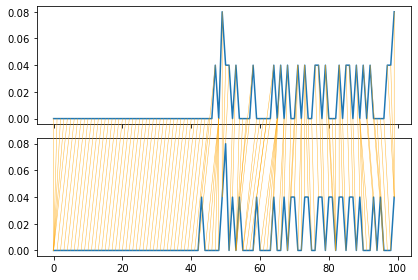

In [137]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
s1 = df.iloc[4].values.astype(np.double)
s2 = df.iloc[6].values.astype(np.double)
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(
    s1, s2, path,
    # filename="./image/warp.png"
    )

In [166]:
# dump regions name as a JSON file

import json

df_dist = pd.DataFrame(
    ds,
    columns=df.index,
    index=df.index
).replace([np.inf, -np.inf], np.nan)

regions_dict = {}

for region in df_dist.columns:
    
    _regions = df_dist[[region]].dropna().index.tolist()

    # _regions.remove(region)

    if len(_regions) > 1:

        regions_dict[region] = _regions

with open('./data/data.json', 'w', encoding='utf-8') as file:
    json.dump(
        regions_dict,
        file,
        ensure_ascii=False,
        indent=4)

In [167]:
! head ./data/data.json

{
    "UID-46::chr19:29129110-29139243(+)": [
        "UID-46::chr19:29129110-29139243(+)",
        "UID-3776::chr10:49242728-49252137(+)"
    ],
    "UID-64::chr19:55912237-55921740(+)": [
        "UID-64::chr19:55912237-55921740(+)",
        "UID-65::chr19:55912237-55921388(+)"
    ],
    "UID-65::chr19:55912237-55921388(+)": [
